# 01: Data Loading & Inspection

## Setup

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# For seeing outputs
pd.set_option('display.max_colwidth', 300)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Load Data

In [2]:
# Load Reddit CSV
reddit_df = pd.read_csv("../data/processed/reddit_predatory_loan_posts.csv")

# Keep only necessary columns
reddit_df = reddit_df[['post_text', 'label']]
reddit_df.columns = ['text', 'label']  # match column names
reddit_df.head()

,text,label
0,"Yesterday I received dozens of texts, emails, and phone calls from multiple payday lenders saying my application has been accepted. Obviously someone got a hold of my information, but I’m not sure to what extent. The emails have my name and my email address, but I don’t know what other informati...",predatory
1,Does anyone have any experience with defaulting on payday loans specifically in Utah? I have dug a serious hole for myself and I have 4 payday loans I am not able to pay on and l'm wondering what advice anyone has on how to tackle this.,predatory
2,"Hi, so I am in assistance of needing around 1.8k basically for my car repair. A new used car that I got from carmax a few weeks ago. I did something horribly stupid and I realized it is MY fault and now I have no help in getting the money to fix the issue. I'm 18 years old and I have been trying...",predatory
3,Just wondering if it’s even worth it to try,predatory
4,"Hi, I know this is already painting me as a stupid person but I really need help. I have multiple payday loans totaling to over $600 a paycheck. It would cost me $2500 to pay these loans outright, which I don't have. I am also in a bit of credit card debt, totaling also around $2500. I am 21, an...",predatory


In [3]:
# Load Loan Documents
labels_df = pd.read_csv("../data/metadata/data_labels.csv")

# Fix column names (remove accidental spaces)
labels_df.columns = [col.strip() for col in labels_df.columns]

# Load texts
texts = []

for idx, row in labels_df.iterrows():
    fname = row["filename"]
    label = row["label"]

    if label == "predatory":
        file_path = os.path.join("../data/raw/loan_documents/predatory", fname)
    else:
        file_path = os.path.join("../data/raw/loan_documents/non_predatory", fname)

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        text = ""

    texts.append(text)

labels_df['text'] = texts

# Prepare loan docs dataframe
loan_docs_df = labels_df[['text', 'label']]
loan_docs_df.head()



File not found: ../data/raw/loan_documents/non_predatory/speedy_cash_payday_desc.txt
File not found: ../data/raw/loan_documents/non_predatory/big_picture_loans_info.txt
File not found: ../data/raw/loan_documents/non_predatory/ace_cash_express_loan_page.txt
File not found: ../data/raw/loan_documents/non_predatory/check_city_payday_loan_info.txt
File not found: ../data/raw/loan_documents/non_predatory/cashnetusa_alternative_marketing.txt
File not found: ../data/raw/loan_documents/non_predatory/check_n_go_payday_loan_page.txt


,text,label
0,,predatory
1,,predatory
2,,predatory
3,,predatory
4,,predatory


In [4]:
# Combine everything
full_df = pd.concat([loan_docs_df, reddit_df], axis=0).reset_index(drop=True)
full_df = full_df.dropna(subset=["text"])  # Drop empty texts

print(full_df.shape)
print(full_df['label'].value_counts())

full_df.head()

(31, 2)
label
predatory         20
 predatory         6
 non_predatory     5
Name: count, dtype: int64


,text,label
0,,predatory
1,,predatory
2,,predatory
3,,predatory
4,,predatory


## Train Test Split + Vectorization

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    full_df['text'],
    full_df['label'],
    test_size=0.2,
    random_state=42,
    stratify=full_df['label']
)


/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [6]:
# Create a TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,    # Cap at 5000 top features
    ngram_range=(1,2),    # Unigrams + bigrams
    stop_words='english'  # Remove common stopwords
)

# Fit on train only
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

print(f"Train TF-IDF shape: {X_train_vec.shape}")
print(f"Test TF-IDF shape: {X_test_vec.shape}")


Train TF-IDF shape: (24, 5000)
Test TF-IDF shape: (7, 5000)


## Train Log Regression

In [7]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_vec, y_train)
y_pred_lr = lr.predict(X_test_vec)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))


/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Logistic Regression Classification Report:
                precision    recall  f1-score   support

 non_predatory       0.00      0.00      0.00         1
     predatory       0.00      0.00      0.00         1
     predatory       0.71      1.00      0.83         5

      accuracy                           0.71         7
     macro avg       0.24      0.33      0.28         7
  weighted avg       0.51      0.71      0.60         7



/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

In [10]:
### function to plot confusion matrices
from sklearn.metrics import confusion_matrix
def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=["predatory", "non_predatory"])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["predatory", "non_predatory"], yticklabels=["predatory", "non_predatory"])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

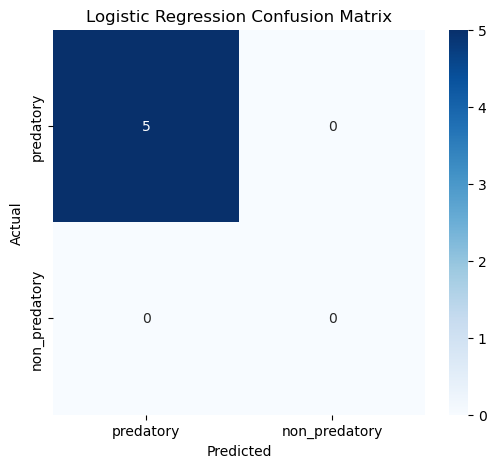

In [11]:
# confusion matrix for Logistic Regression
plot_confusion(y_test, y_pred_lr, "Logistic Regression Confusion Matrix")

## Naive Bayes Classifier

In [12]:
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)

# Predict
y_pred_nb = nb.predict(X_test_vec)

# Evaluate
print("=== Naive Bayes Classification Report ===")
print(classification_report(y_test, y_pred_nb))


=== Naive Bayes Classification Report ===
                precision    recall  f1-score   support

 non_predatory       0.00      0.00      0.00         1
     predatory       0.00      0.00      0.00         1
     predatory       0.71      1.00      0.83         5

      accuracy                           0.71         7
     macro avg       0.24      0.33      0.28         7
  weighted avg       0.51      0.71      0.60         7



/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

## Train Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)
y_pred_rf = rf.predict(X_test_vec)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
                precision    recall  f1-score   support

 non_predatory       0.00      0.00      0.00         1
     predatory       0.20      1.00      0.33         1
     predatory       1.00      0.40      0.57         5

      accuracy                           0.43         7
     macro avg       0.40      0.47      0.30         7
  weighted avg       0.74      0.43      0.46         7



/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

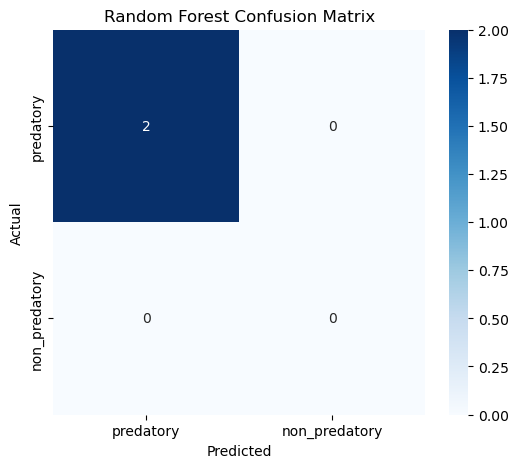

In [14]:
# Confusion matrix For Random Forest
plot_confusion(y_test, y_pred_rf, "Random Forest Confusion Matrix")

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Define a helper function
# Define a helper function for multiclass
def evaluate_model(name, y_true, y_pred, results=[]):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    results.append({
        'Model': name,
        'Precision': round(precision, 2),
        'Recall': round(recall, 2),
        'F1-Score': round(f1, 2)
    })
    return results

# Initialize results list
results = []

# Evaluate each model
results = evaluate_model("Logistic Regression", y_test, y_pred_lr, results)
results = evaluate_model("Naive Bayes", y_test, y_pred_nb, results)
results = evaluate_model("Random Forest", y_test, y_pred_rf, results)

# Turn into DataFrame
results_df = pd.DataFrame(results)

# Display
results_df


/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/seun/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_

,Model,Precision,Recall,F1-Score
0,Logistic Regression,0.51,0.71,0.60
1,Naive Bayes,0.51,0.71,0.60
2,Random Forest,0.74,0.43,0.46
